In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, ParameterSampler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from scipy.stats import randint
import warnings
warnings.filterwarnings("ignore")

# 데이터 로드 및 전처리
data = pd.read_csv('facility_data.csv')
data_cleaned = data.drop(columns=['Unnamed: 0', 'ID'])

# 범주형 변수 원-핫 인코딩
data_cleaned = pd.get_dummies(data_cleaned, columns=['COMPONENT_ARBITRARY'])

# 특성과 타겟 변수 분리
X = data_cleaned.drop(columns=['Y_LABEL'])
y = data_cleaned['Y_LABEL']

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [2]:
# 모델 생성 함수
def create_model(optimizer='adam', learning_rate=0.001):
    model = Sequential([
        Dense(64, input_dim=X_scaled.shape[1], activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 랜덤 서치를 위한 파라미터 분포 정의
param_dist = {
    'epochs': randint(10, 30),
    'batch_size': [32, 64],
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'learning_rate': [0.001, 0.01]
}

best_score = 0
best_params = {}

# 파라미터 조합 수를 줄이기 위해 n_iter를 5로 설정
param_list = list(ParameterSampler(param_dist, n_iter=5, random_state=42))

for params in param_list:
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = []

    for train, test in kfold.split(X_scaled):
        model = create_model(optimizer=params['optimizer'], learning_rate=params['learning_rate'])
        model.fit(X_scaled[train], y[train], epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
        score = model.evaluate(X_scaled[test], y[test], verbose=0)[1]
        scores.append(score)

    mean_score = np.mean(scores)
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print("Best parameters found by RandomSearch:")
print(best_params)
print(f"Best score: {best_score:.4f}")

# 최적의 파라미터로 최종 모델 학습
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

final_model = create_model(optimizer=best_params['optimizer'], learning_rate=best_params['learning_rate'])
final_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=2)

# 테스트 세트에서 최종 모델 평가
test_loss, test_accuracy = final_model.evaluate(X_test, y_test, verbose=0)

print(f'Final Test Accuracy: {test_accuracy}')

Best parameters found by RandomSearch:
{'batch_size': 32, 'epochs': 17, 'learning_rate': 0.001, 'optimizer': 'adam'}
Best score: 0.9533
Epoch 1/17
353/353 - 3s - 8ms/step - accuracy: 0.9163 - loss: 0.2888
Epoch 2/17
353/353 - 1s - 2ms/step - accuracy: 0.9314 - loss: 0.2323
Epoch 3/17
353/353 - 1s - 2ms/step - accuracy: 0.9384 - loss: 0.2118
Epoch 4/17
353/353 - 1s - 2ms/step - accuracy: 0.9438 - loss: 0.1983
Epoch 5/17
353/353 - 1s - 2ms/step - accuracy: 0.9461 - loss: 0.1891
Epoch 6/17
353/353 - 1s - 2ms/step - accuracy: 0.9487 - loss: 0.1838
Epoch 7/17
353/353 - 1s - 2ms/step - accuracy: 0.9502 - loss: 0.1771
Epoch 8/17
353/353 - 1s - 3ms/step - accuracy: 0.9518 - loss: 0.1735
Epoch 9/17
353/353 - 1s - 3ms/step - accuracy: 0.9530 - loss: 0.1722
Epoch 10/17
353/353 - 1s - 4ms/step - accuracy: 0.9513 - loss: 0.1720
Epoch 11/17
353/353 - 2s - 5ms/step - accuracy: 0.9534 - loss: 0.1664
Epoch 12/17
353/353 - 1s - 2ms/step - accuracy: 0.9518 - loss: 0.1669
Epoch 13/17
353/353 - 1s - 2ms/st

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Test Accuracy: 0.9276339127350124
Test Precision: 1.0
Test Recall: 0.1091703056768559
Test F1 Score: 0.1968503937007874
Test AUC: 0.7865488695183019


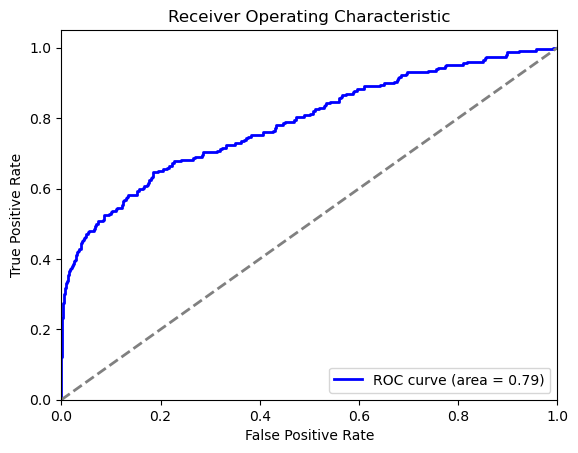

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 테스트 세트에서 모델 평가
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_prob)

print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Test F1 Score: {test_f1}')
print(f'Test AUC: {test_auc}')

# ROC 곡선 출력
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [8]:
%%capture

# SHAP를 통한 변수 중요도 점검
import shap

# 데이터 양이 많아 시간이 오래 걸릴 수 있기 때문에 테스트 데이터의 일부만 활용합니다
sample_indices = np.random.choice(X_test.shape[0], size=100, replace=False)
X_test_sample = X_test[sample_indices]

# Explainer 객체 생성
explainer = shap.Explainer(model.predict, X_test_sample)

# SHAP 값 계산
shap_values = explainer(X_test_sample)

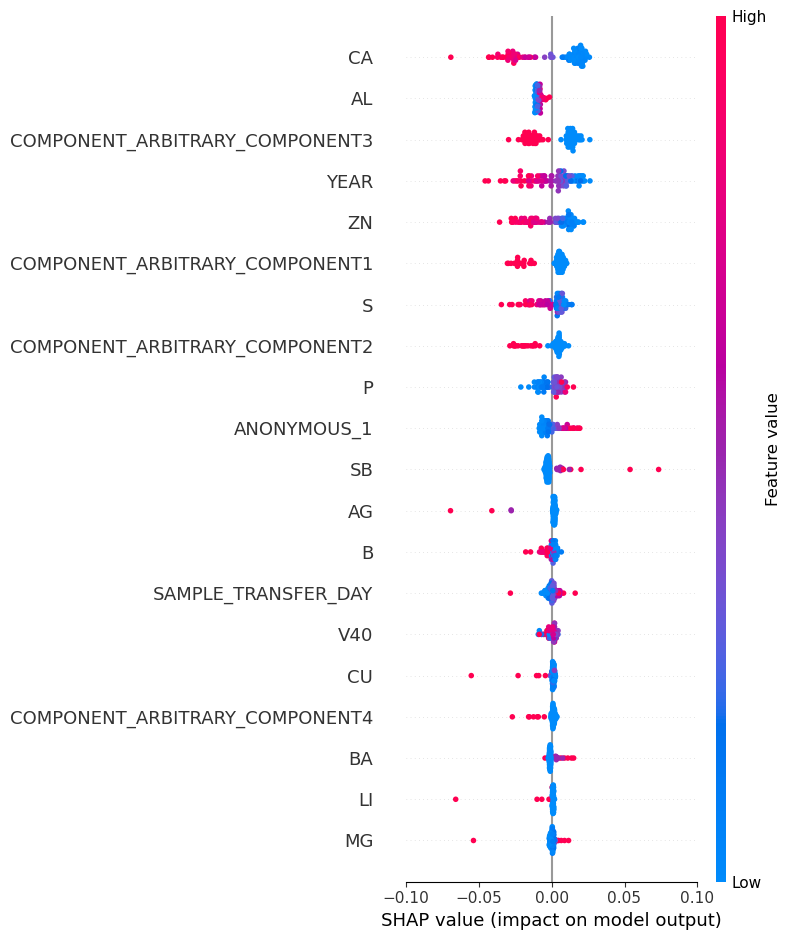

In [16]:
# Feature 중요도 요약
shap.summary_plot(shap_values, X_test_sample, feature_names=X.columns, show=False)

# 현재 axes 객체 가져오기
ax = plt.gca()

# x축 범위 설정
ax.set_xlim(-0.1, 0.1)

# 그래프 표시
plt.tight_layout()
plt.show()